# ESG Publishment Data Preprocessing

In this notebook we pre-processed scholar data and implemented feature engineering.

@ Chris Chen 
 
@ 2020-03-07

In [1]:
import pandas as pd
import numpy as np
import requests
import ast
from PIL import Image
from wordcloud import WordCloud

import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import coo_matrix
import math

In [3]:
path = '/Users/ChrisQAQ/Downloads/ICAF_2020/ESG/data1/'
# load papers data
paper_df = pd.read_csv(path + 'scholar_data/papers.csv')

In [4]:
paper_df.head()

,company,company_query_name,id,title,paper_type,paper_year,paper_date,citation,citation_estimated,Authors,Fields_of_study,J_or_C_name,J_or_C_id,keywords,logprob
0,Apple Inc.,apple inc,2504791311,electric switchboard and circuits,Patents,1901,1901-08-24,0,0,"[{'AuN': 'apple vincent g', 'AuId': 2567700084...","[{'FN': 'electronic engineering', 'FId': 24326...",NaN,NaN,"circuits,electric,switchboard",-35.332
1,Apple Inc.,apple inc,2418830571,machine for packing pulverulent and mastic sub...,Patents,1902,1902-07-19,1,1,"[{'AuN': 'apple vincent g', 'AuId': 2567700084...","[{'FN': 'materials science', 'FId': 192562407}...",NaN,NaN,"machine,mastic,packing,pulverulent,substances",-33.433
2,Apple Inc.,apple inc,2464829574,device for storing and administering serums,Patents,1903,1903-03-07,12,12,"[{'AuN': 'william s apple', 'AuId': 2597534574...","[{'FN': 'materials science', 'FId': 192562407}]",NaN,NaN,"administering,device,serums,storing",-29.493
3,Apple Inc.,apple inc,2423344776,zinc cup for primary batteries,Patents,1903,1903-03-23,1,1,"[{'AuN': 'apple vincent g', 'AuId': 2567700084...","[{'FN': 'zinc', 'FId': 535196362}, {'FN': 'met...",NaN,NaN,"batteries,cup,primary,zinc",-34.178
4,Apple Inc.,apple inc,2413303928,automatic friction governor,Patents,1903,1903-05-02,0,0,"[{'AuN': 'apple vincent g', 'AuId': 2567700084...","[{'FN': 'governor', 'FId': 2781233147}, {'FN':...",NaN,NaN,"automatic,friction,governor",-35.127


# Scholar Data Parsing

In [5]:
def Process_Authors(dict_str):
    author_dict = ast.literal_eval(str(dict_str)[1:-1])

    au_id = []
    au_name = []
    af_id = []
    af_name = []
    
    if type(author_dict) is not dict:
        for d in author_dict:
            if 'AuId' in d:
                au_id.append(d['AuId'])
            if 'AfId' in d:
                af_id.append(d['AfId'])
            if 'AuN' in d:
                au_name.append(d['AuN'])
            if 'AfN' in d:
                af_name.append(d['AfN'])
    else:
        if 'AuId' in author_dict:
            au_id.append(author_dict['AuId'])
        if 'AfId' in author_dict:
            af_id.append(author_dict['AfId'])
        if 'AuN' in author_dict:
            au_name.append(author_dict['AuN'])
        if 'AfN' in author_dict:
            af_name.append(author_dict['AfN'])
    
    return {'AuId': list(set(au_id)), 'AfId': list(set(af_id)),
            'AuN': list(set(au_name)), 'AfN': list(set(af_name))}

def Process_Fields(dict_str):
    if type(dict_str) is float:
        return {'FId': None, 'FN': None}
    
    field_dict = ast.literal_eval(str(dict_str)[1:-1])

    f_id, f_name = [], []
    
    if type(field_dict) is not dict:
        for d in field_dict:
            if 'FId' in d:
                f_id.append(d['FId'])
            if 'FN' in d:
                f_name.append(d['FN'])
    else:
        if 'FId' in field_dict:
            f_id.append(field_dict['FId'])
        if 'FN' in field_dict:
            f_name.append(field_dict['FN'])
    
    return {'FId': list(set(f_id)), 'FN': list(set(f_name))}


unique_paper_df = paper_df[['id', 'title', 'paper_type', 'paper_date', 'citation',
                            'Authors', 'Fields_of_study', 'keywords']].drop_duplicates()
unique_paper_df['Author_processed'] = unique_paper_df['Authors'].apply(Process_Authors)
unique_paper_df[['AuId', 'AfId', 'AuN', 'AfN']] = unique_paper_df['Author_processed'].apply(pd.Series)
unique_paper_df['keywords_processed'] = unique_paper_df.keywords.apply(lambda x:x.split(','))
unique_paper_df['Field_processed'] = unique_paper_df['Fields_of_study'].apply(Process_Fields)
unique_paper_df[['FId', 'FN']] = unique_paper_df['Field_processed'].apply(pd.Series)


In [11]:
keyword_list = []
for keyword in unique_paper_df['keywords_processed']:
    for word in keyword:
        keyword_list.append(str(word))
        
author_list = []
for author in unique_paper_df['AuId']:
    for id in author:
        author_list.append(str(id))

affliation_list = []
for af in unique_paper_df['AfId']:
    for id in af:
        affliation_list.append(str(id))
        
field_list = []
for fn in unique_paper_df['FN']:
    if fn is None:
        continue
    for n in fn:
        field_list.append(str(n))

In [12]:
print(f'# of papers: {len(unique_paper_df)}')
print(f'# of keywords: {len(set(keyword_list))}')
print(f'# of authors: {len(set(author_list))}')
print(f'# of affliations: {len(set(affliation_list))}')
print(f'# of fields: {len(set(field_list))}')

# of papers: 737391
# of keywords: 119155
# of authors: 706743
# of affliations: 6487
# of fields: 59642


In [13]:
print(len(set(author_list).intersection(set(affliation_list))))
print(len(set(author_list).intersection(set(keyword_list))))
print(len(set(keyword_list).intersection(set(affliation_list))))
print(len(set(keyword_list).intersection(set(field_list))))
# which shows no confliction of feature names?

0
0
0
9470


In [14]:
unique_paper_df.paper_type.value_counts()

Patents                    510734
Journal publications       105617
Conference publications     86083
Articles                    34547
Books                         368
Others                         42
Name: paper_type, dtype: int64

In [15]:
feature_list = []
unique_paper_df = unique_paper_df.reset_index(drop=True)
for idx in range(len(unique_paper_df)):
    keyword = unique_paper_df['keywords'][idx]
    fn = unique_paper_df['FN'][idx]
    if fn is None:
        feature = keyword
    else:
        fn = [str(i) for i in fn]
        fn = ','.join(fn)
        feature = keyword + ',' + fn
    feature_list.append(feature)
unique_paper_df['features'] = feature_list

# Decomposition
## LDA

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words=None)#stop_words='english'
# a sparse matrix with each row as unique paper and columns as features including auid, afid, and keywords;
count_data = count_vectorizer.fit_transform(unique_paper_df['features'])

# list of features
feature_dict = count_vectorizer.get_feature_names()

print(f'length of features being used: {len(feature_dict)}')
print(f'length of features in raw data: {len(set(keyword_list))+len(set(field_list))-len(set(keyword_list).intersection(set(field_list)))}')

# use LDA transform to reduce matrix dimension / clustering

# the number of clusters can be tuned
# take 20 clusters for example (n_components=20)

lda = LatentDirichletAllocation(n_components=30, max_iter=10, random_state=42)
lda.fit(count_data)

topic_component = lda.transform(count_data)
topic_list = [comp.argmax() for comp in topic_component]
unique_paper_df['topic'] = topic_list


length of features being used: 126018
length of features in raw data: 169327


In [17]:
# interprete the clusters
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
print_top_words(lda, feature_dict, 10)


Topic #0: file, storage, system, computer, data, optical, science, fiber, operating, disk
Topic #1: data, computer, computing, science, database, distributed, time, system, mining, real
Topic #2: management, business, computer, science, process, engineering, system, knowledge, systems, information
Topic #3: web, computer, science, information, wide, world, data, retrieval, database, internet
Topic #4: computer, hardware, science, computing, time, real, data, register, unit, processing
Topic #5: computing, time, real, computer, cache, science, system, bus, parallel, scheduling
Topic #6: optics, laser, optical, beam, optoelectronics, physics, light, materials, radiation, routing
Topic #7: physics, magnetic, resonance, nuclear, matter, condensed, field, chemistry, electron, quantum
Topic #8: computer, video, science, graphics, antenna, coding, motion, frame, point, rendering
Topic #9: computer, system, hardware, science, device, interface, embedded, user, mobile, engineering
Topic #10: en

## WordCloud

In [18]:
def Topic_Word_Cloud(model, feature_names, topic_idx):
    topic = model.components_[topic_idx]
    topic_dict = {feature_names[i]: topic[i] for i in range(len(feature_names))}
    mask = np.array(Image.open('/Users/ChrisQAQ/Downloads/ICAF_2020/ESG/paper_writing/graphs/wordcloud_mask.png'))
    cloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='white', mask=mask)
    cloud.generate_from_frequencies(topic_dict)
    return cloud

def ESG_Word_Cloud(ESG_dict,maxword=5000):
    mask = np.array(Image.open('/Users/ChrisQAQ/Downloads/ICAF_2020/ESG/paper_writing/graphs/wordcloud_mask.png'))
    cloud = WordCloud(background_color="white", max_words=maxword, contour_width=3, contour_color='white', mask=mask)
    cloud.generate_from_frequencies(ESG_dict)
    return cloud

import operator

word_prob = np.array(0)*len(feature_dict)
for topic_idx in [7,12,13,14]:
    word_prob += lda.components_[topic_idx]
ESG_dict = {feature_dict[i]: word_prob[i] for i in range(len(feature_dict))}

ESG_dict = dict(sorted(ESG_dict.items(), key=operator.itemgetter(1),reverse=True))

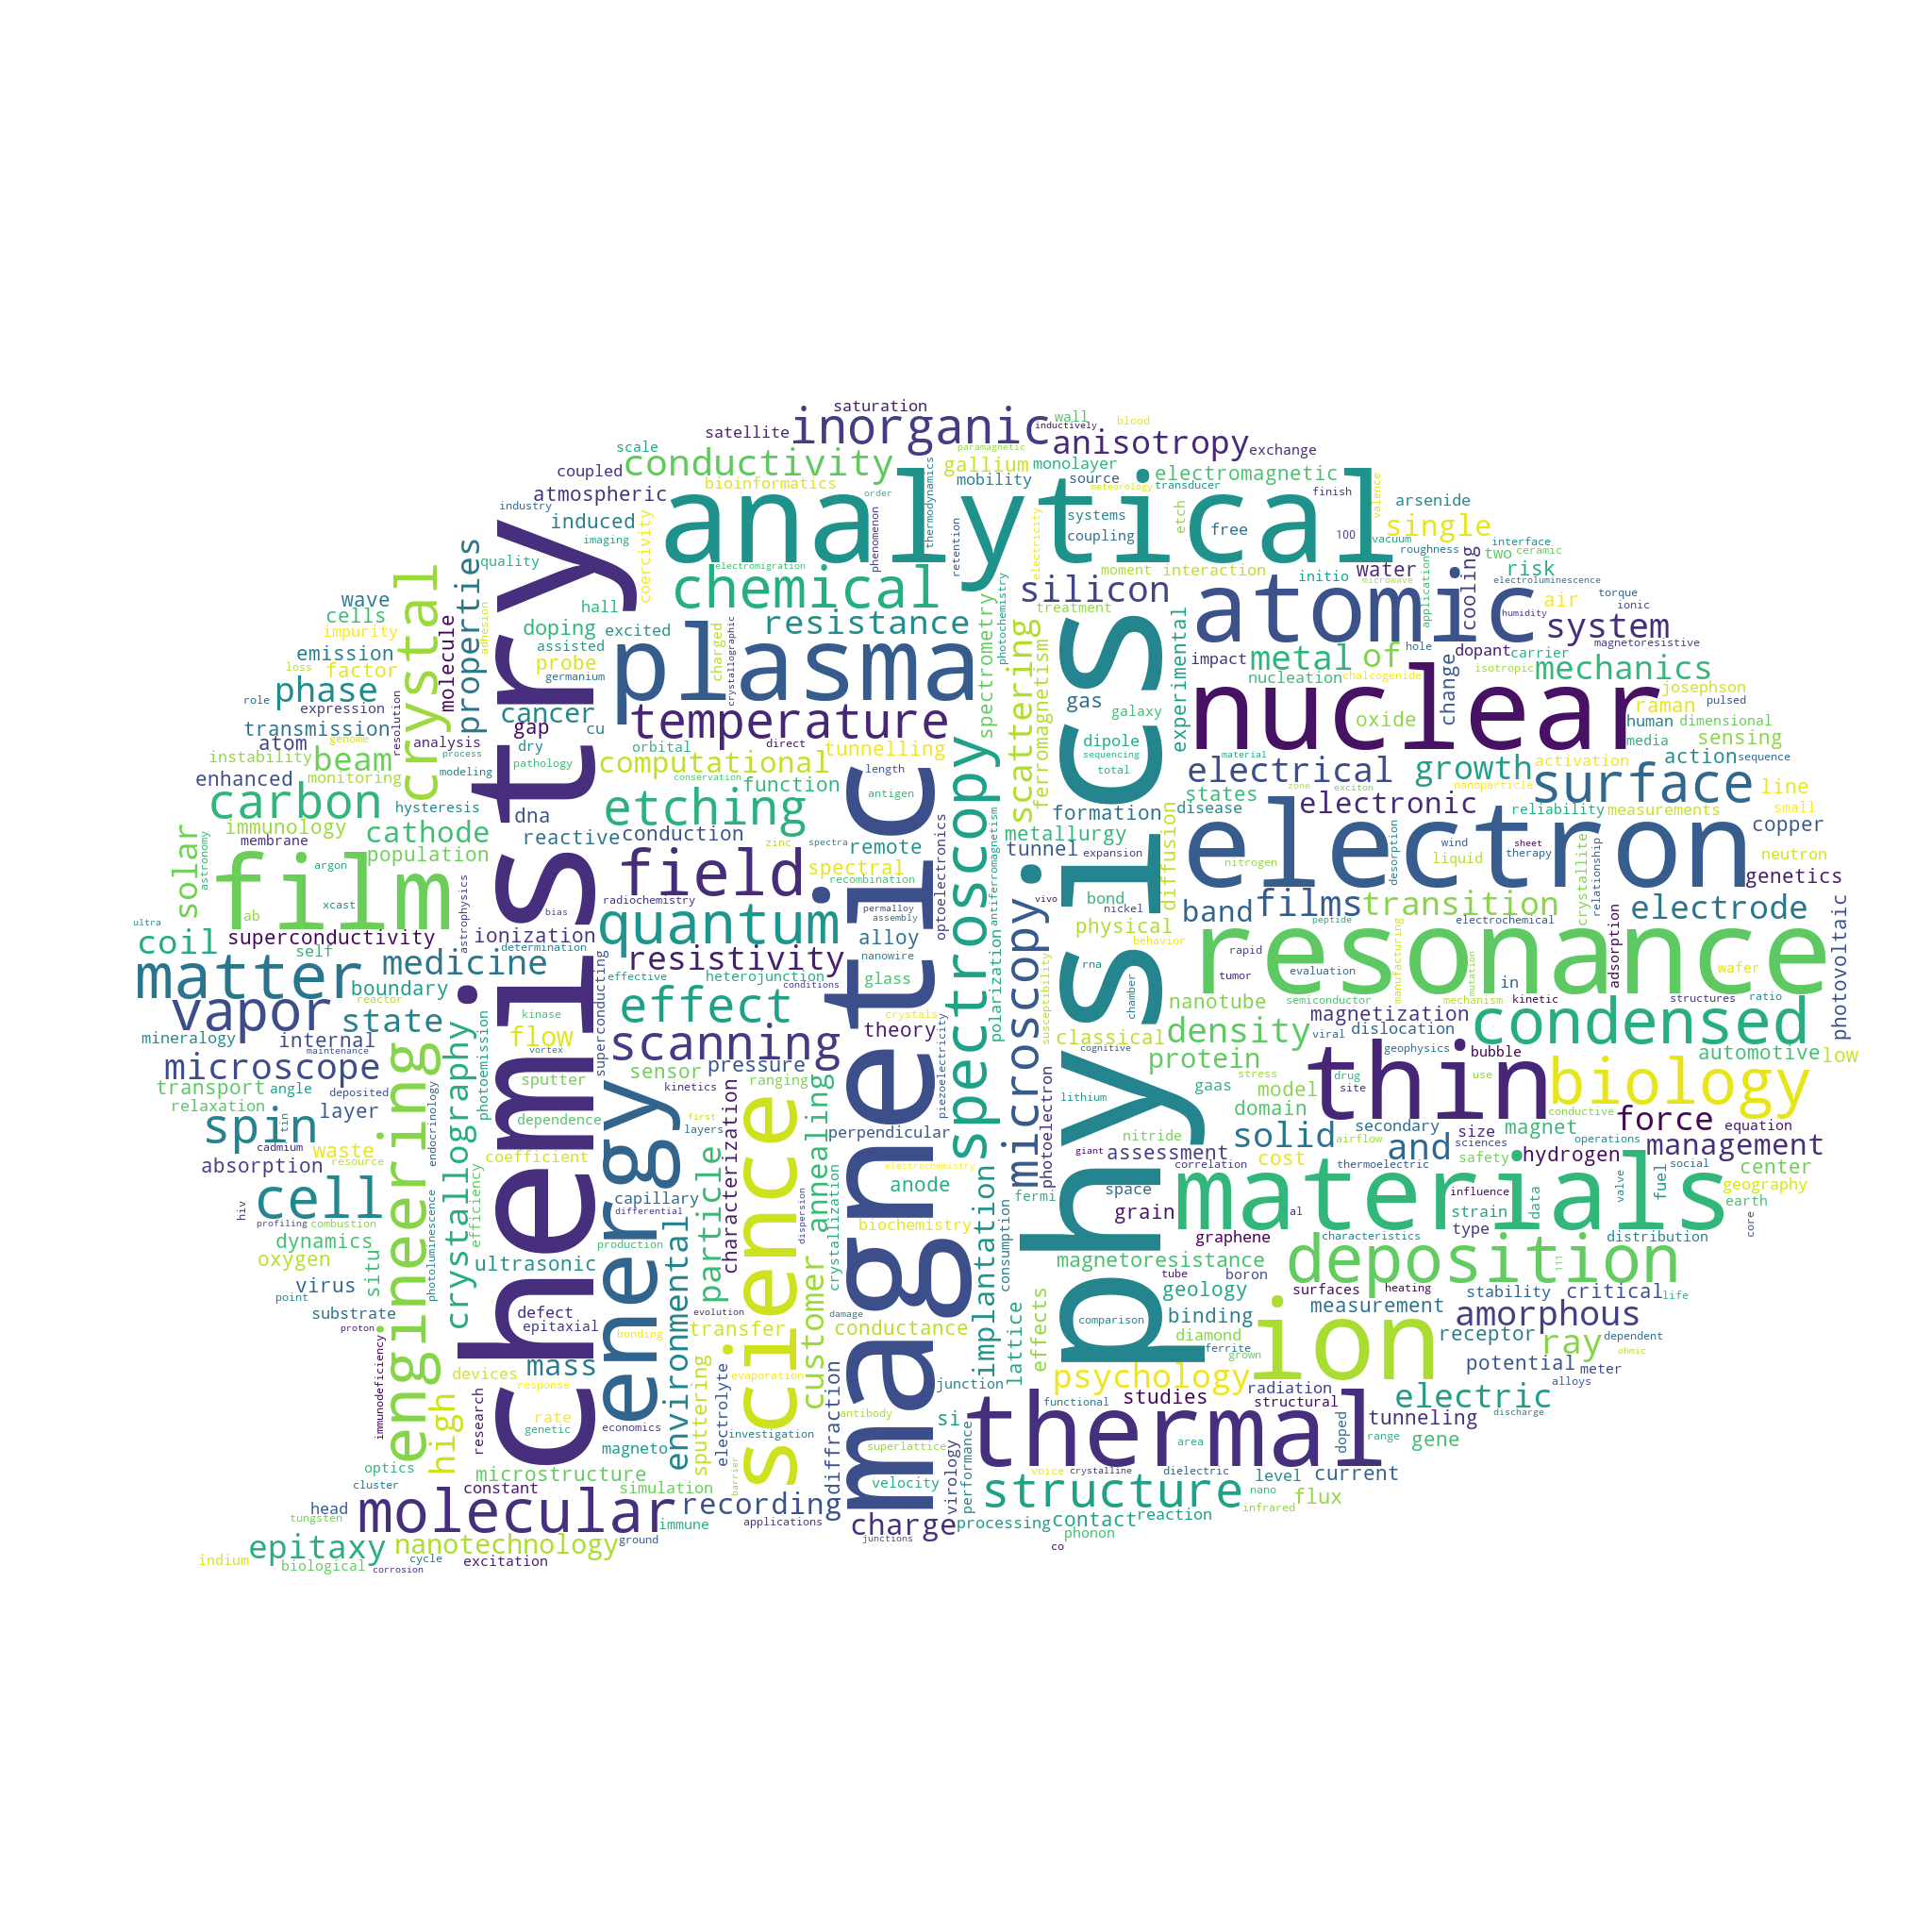

In [19]:
ESG_Word_Cloud(ESG_dict,500).to_image()

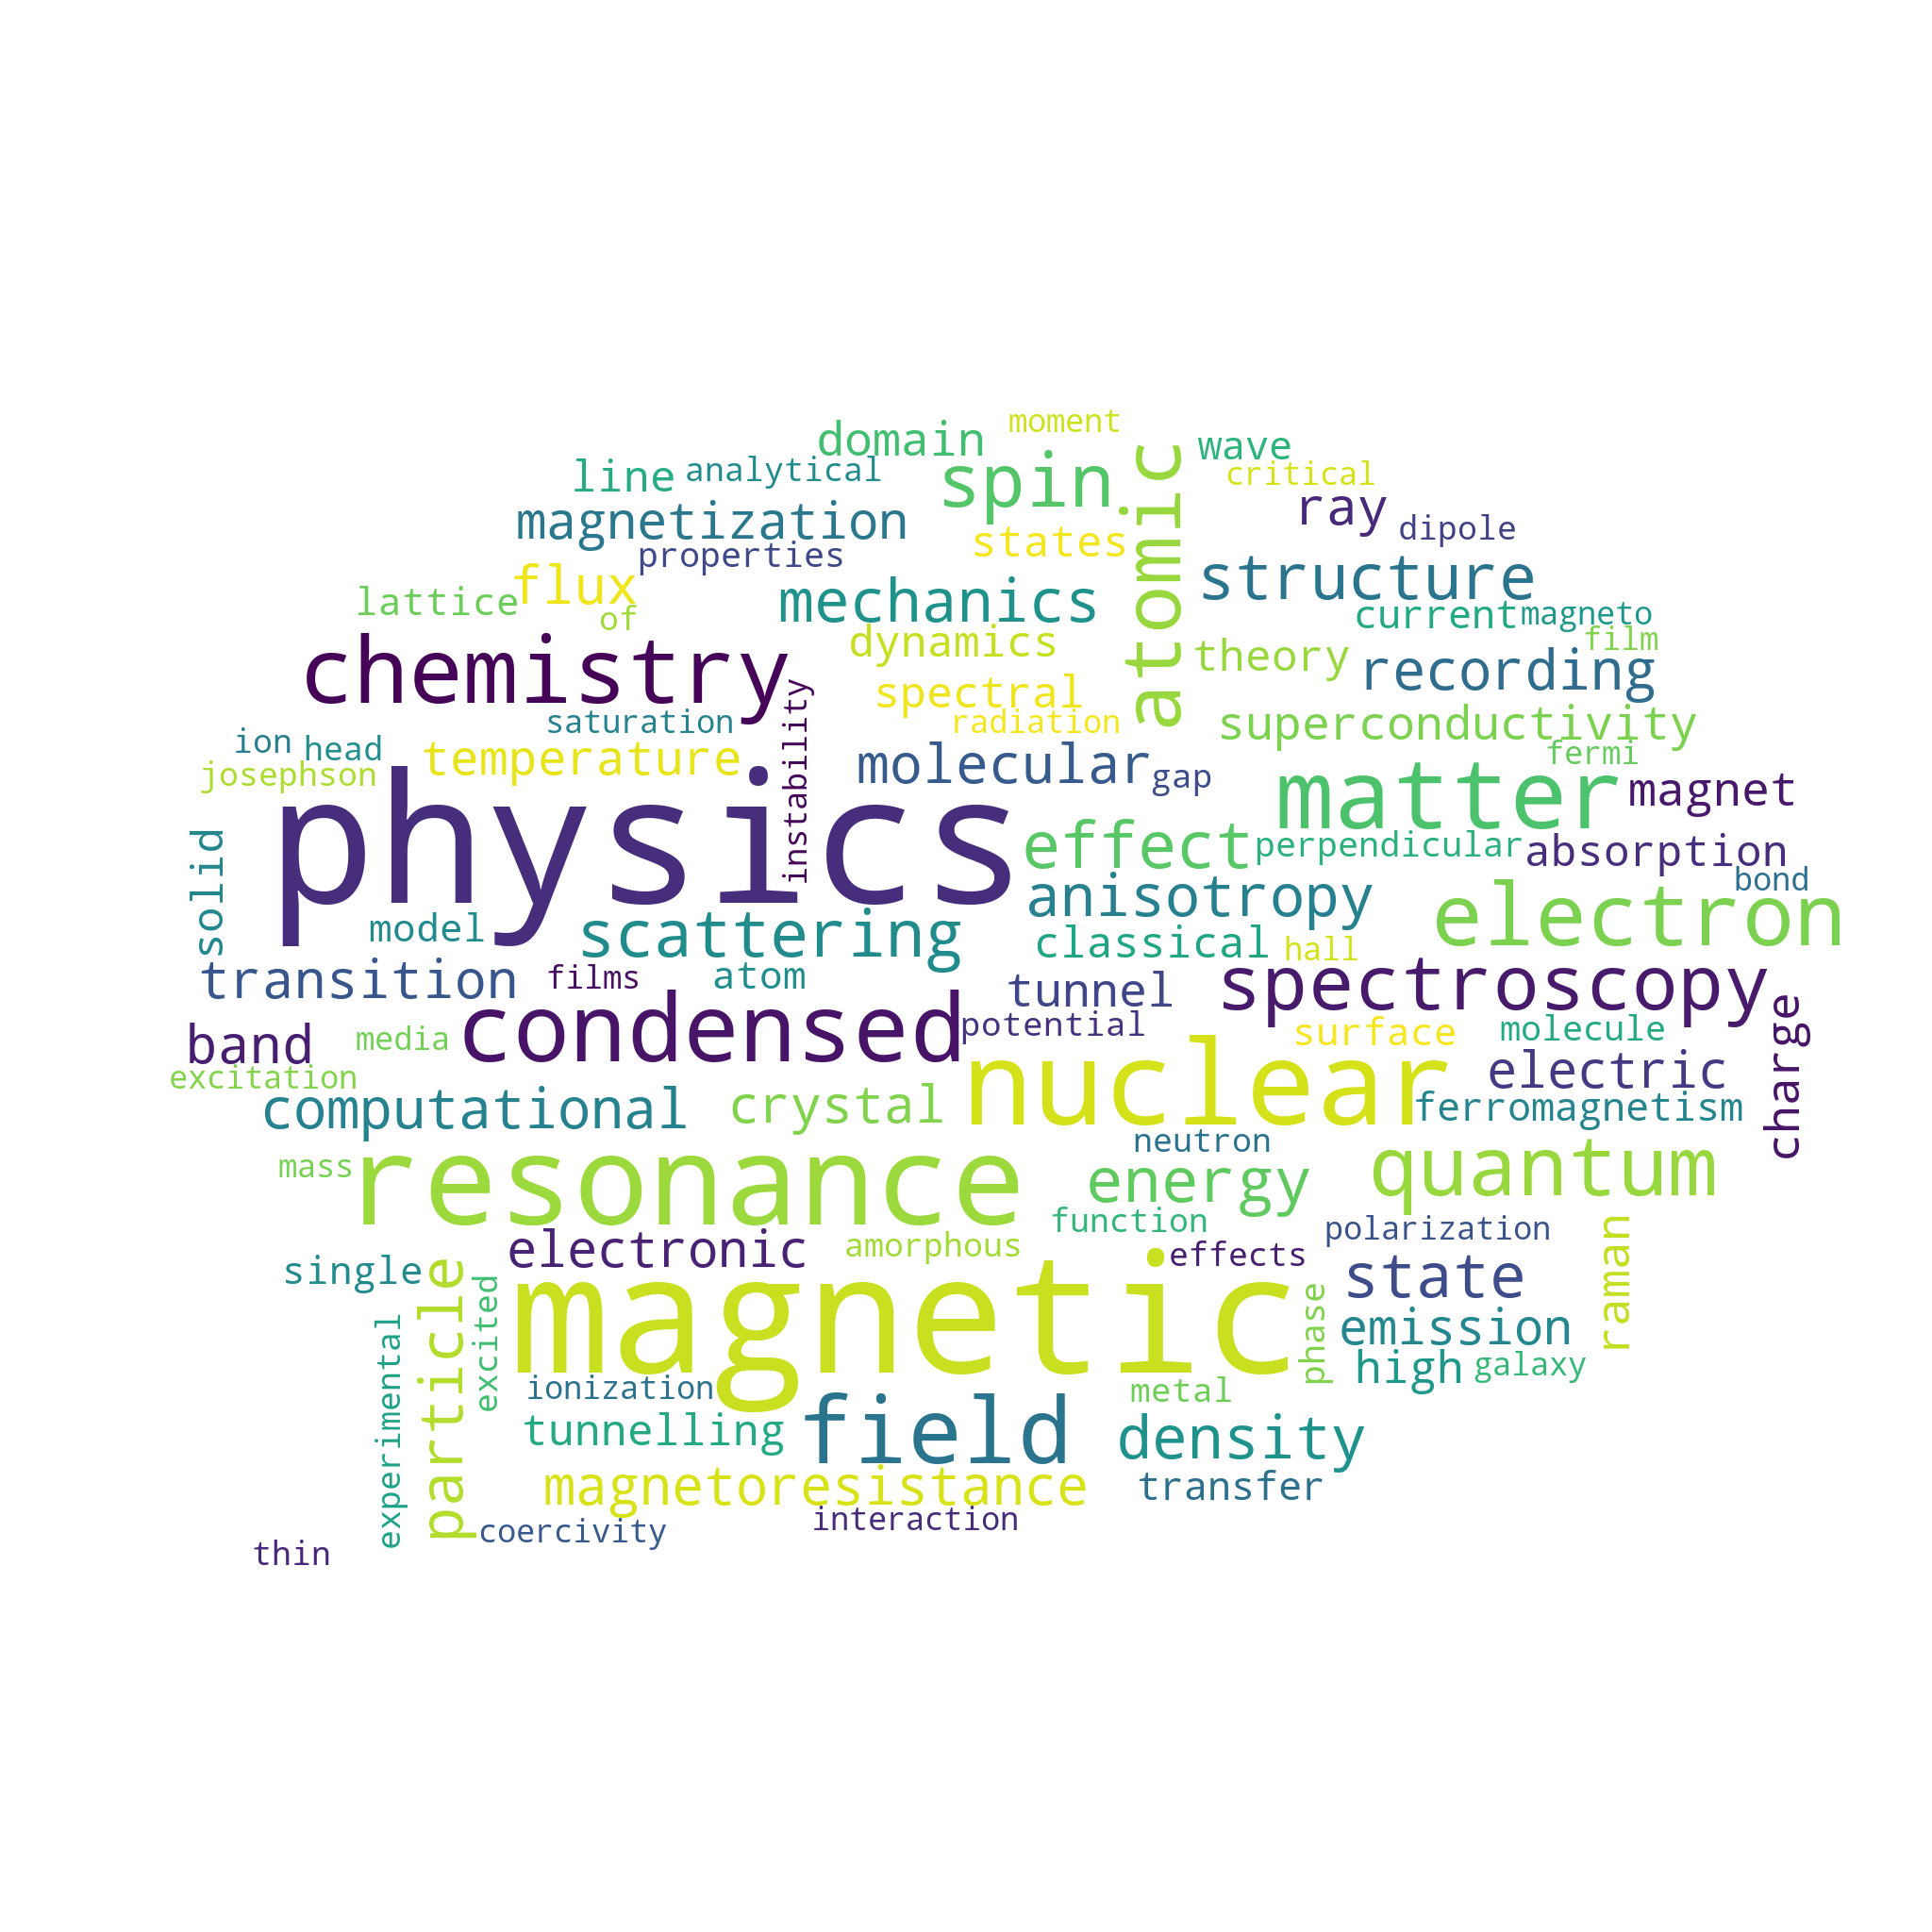

In [22]:
Topic_Word_Cloud(lda, feature_dict, 7).to_image()

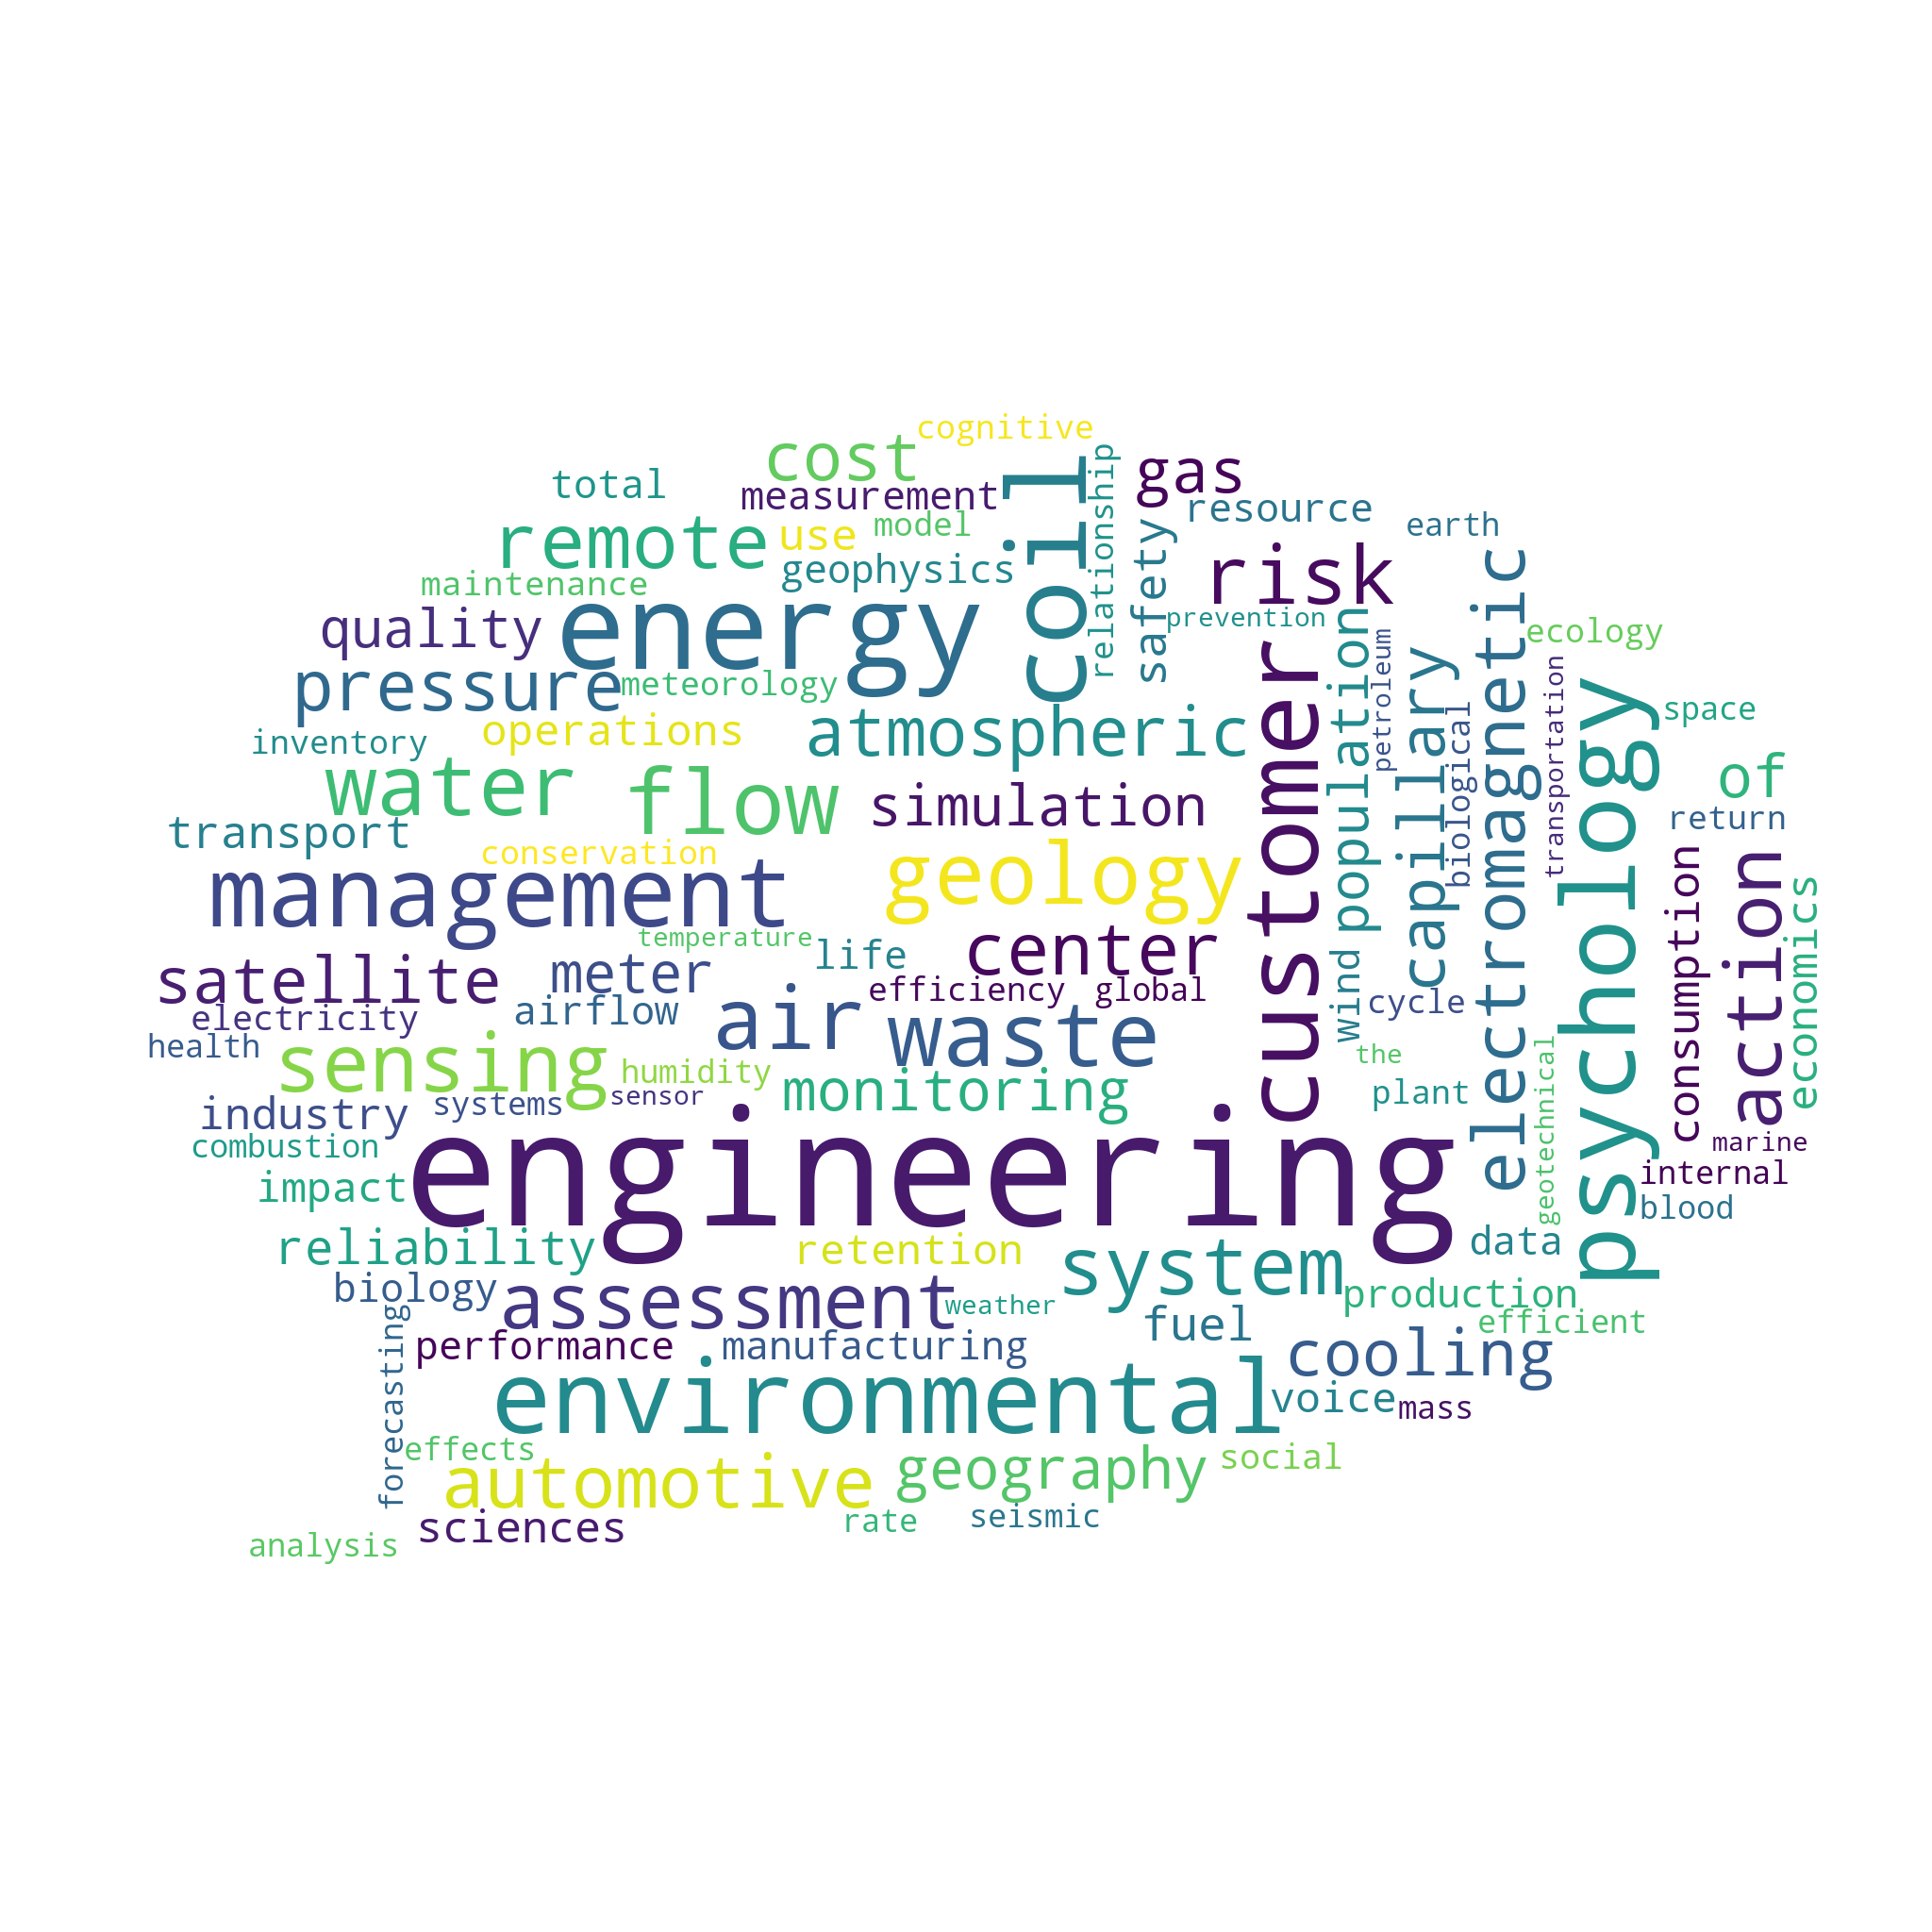

In [20]:
Topic_Word_Cloud(lda, feature_dict, 12).to_image()

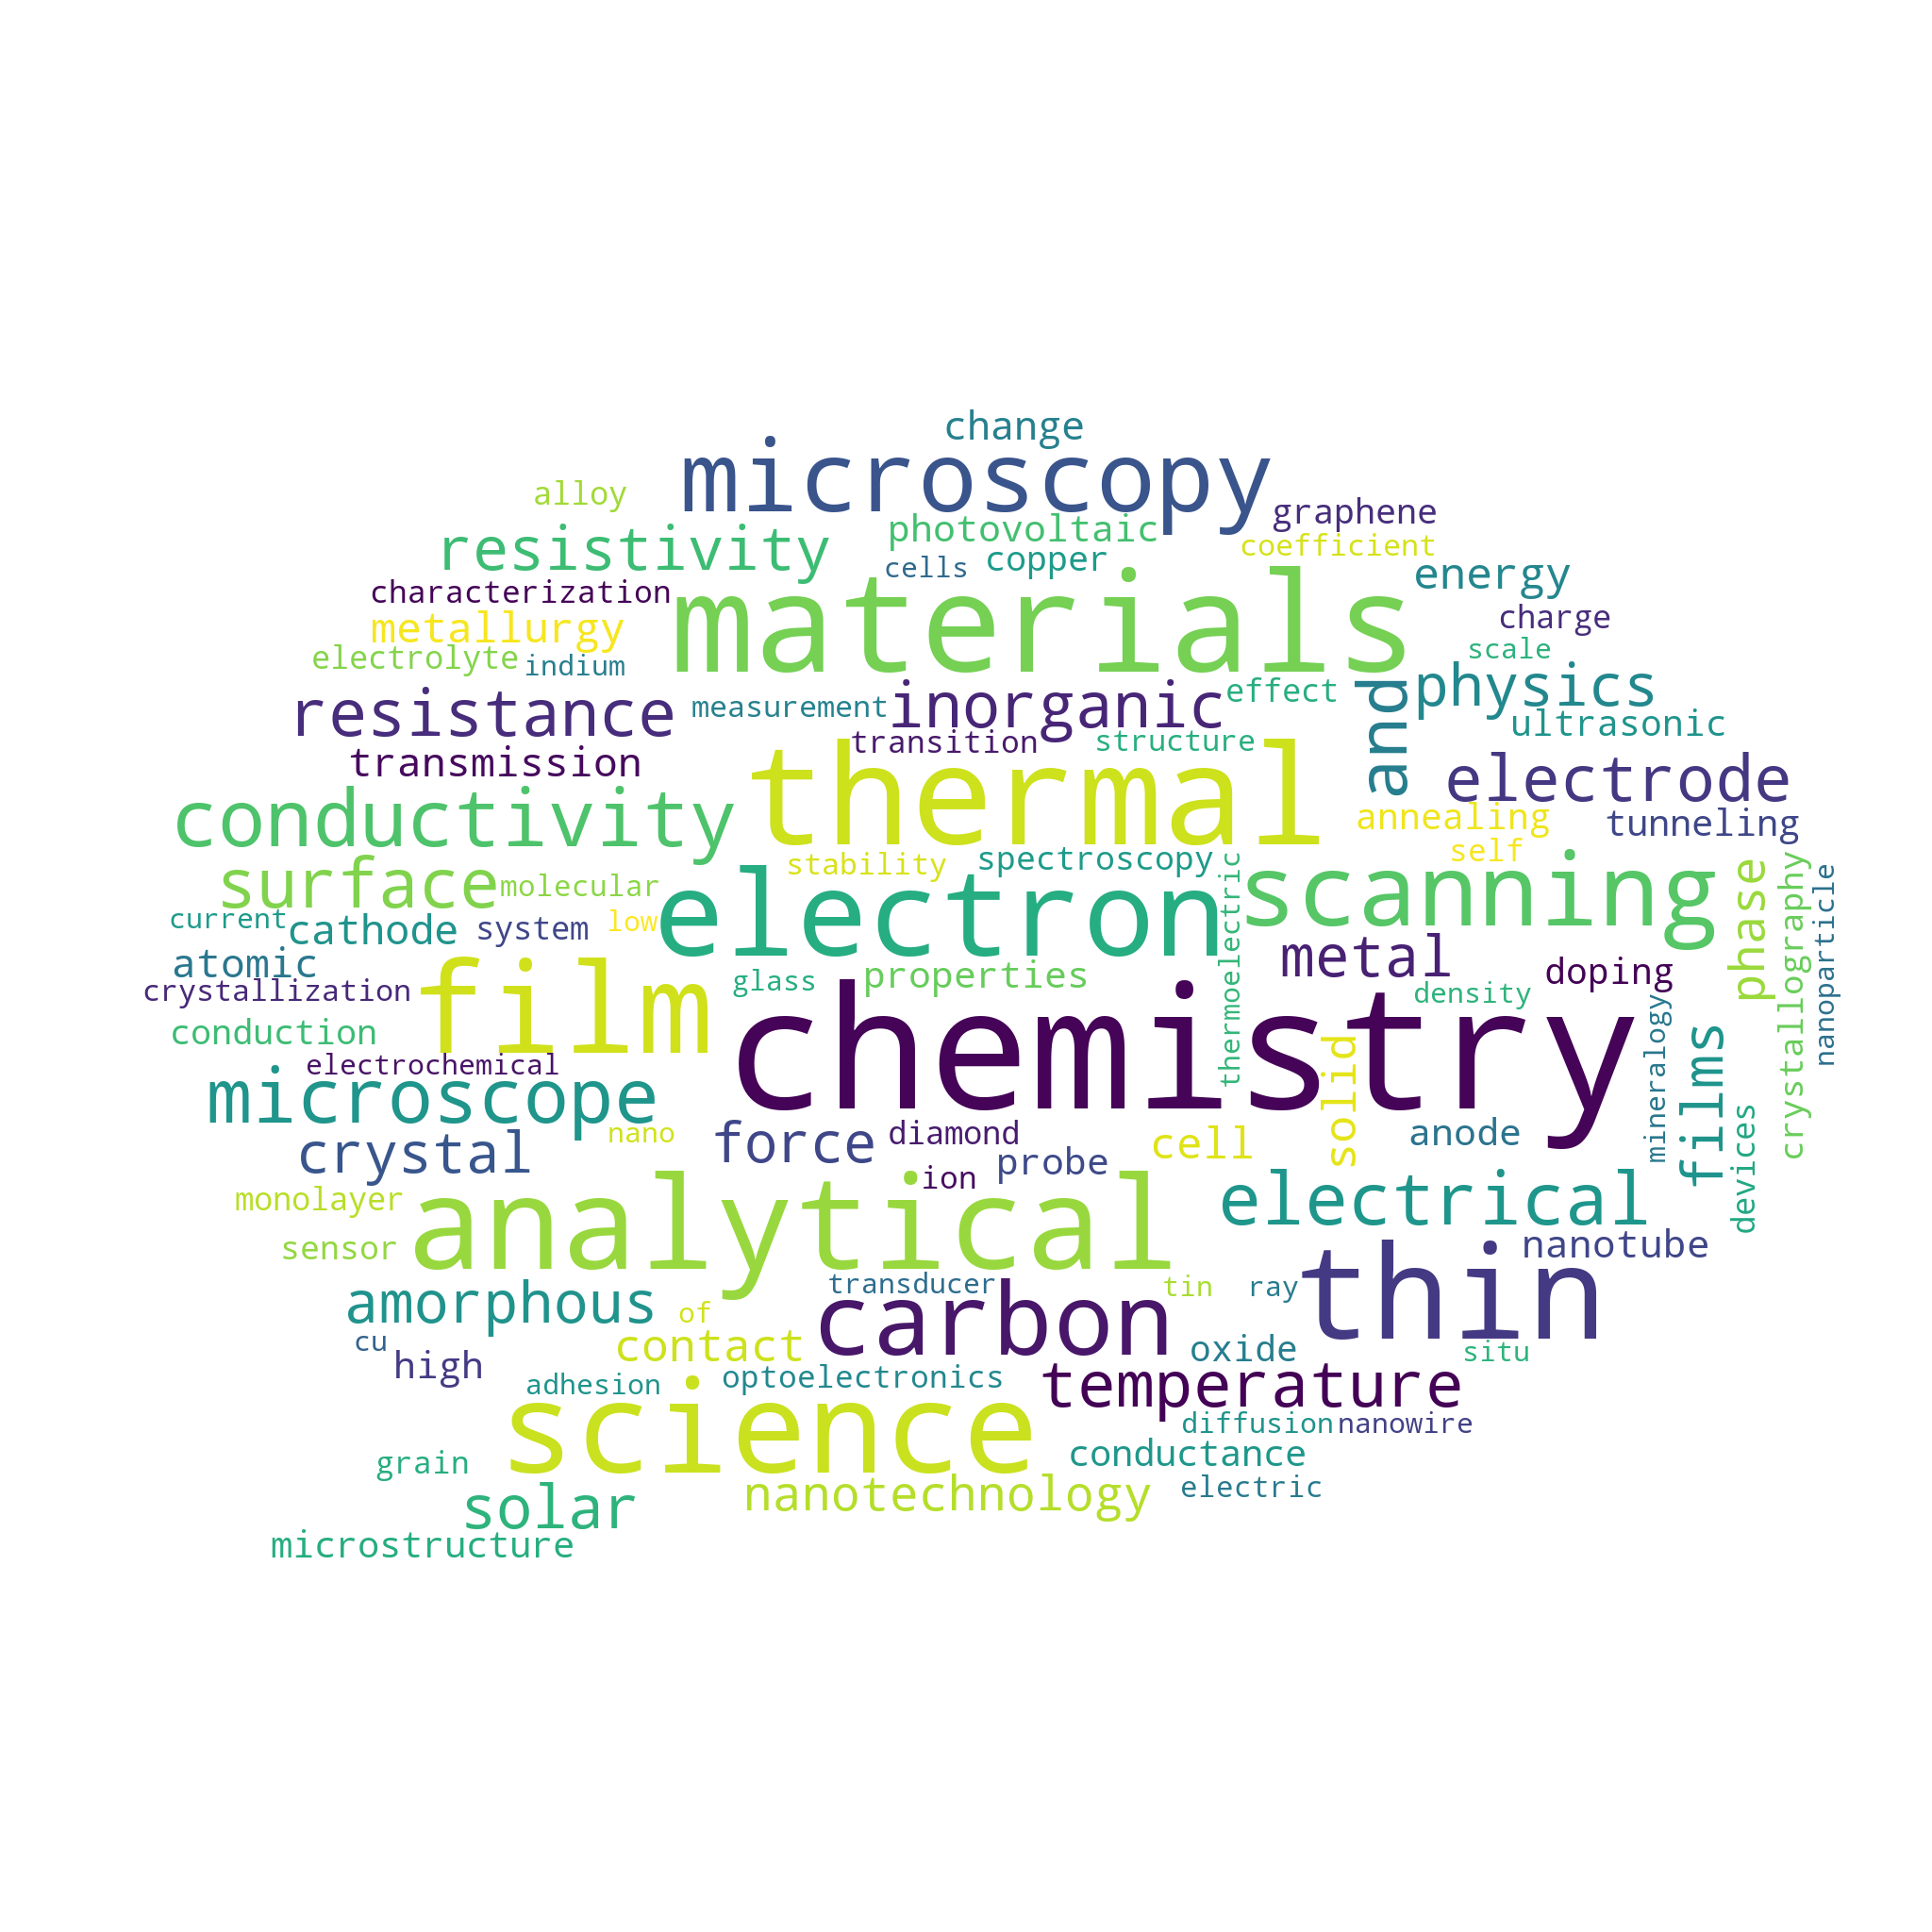

In [23]:
Topic_Word_Cloud(lda, feature_dict, 13).to_image()

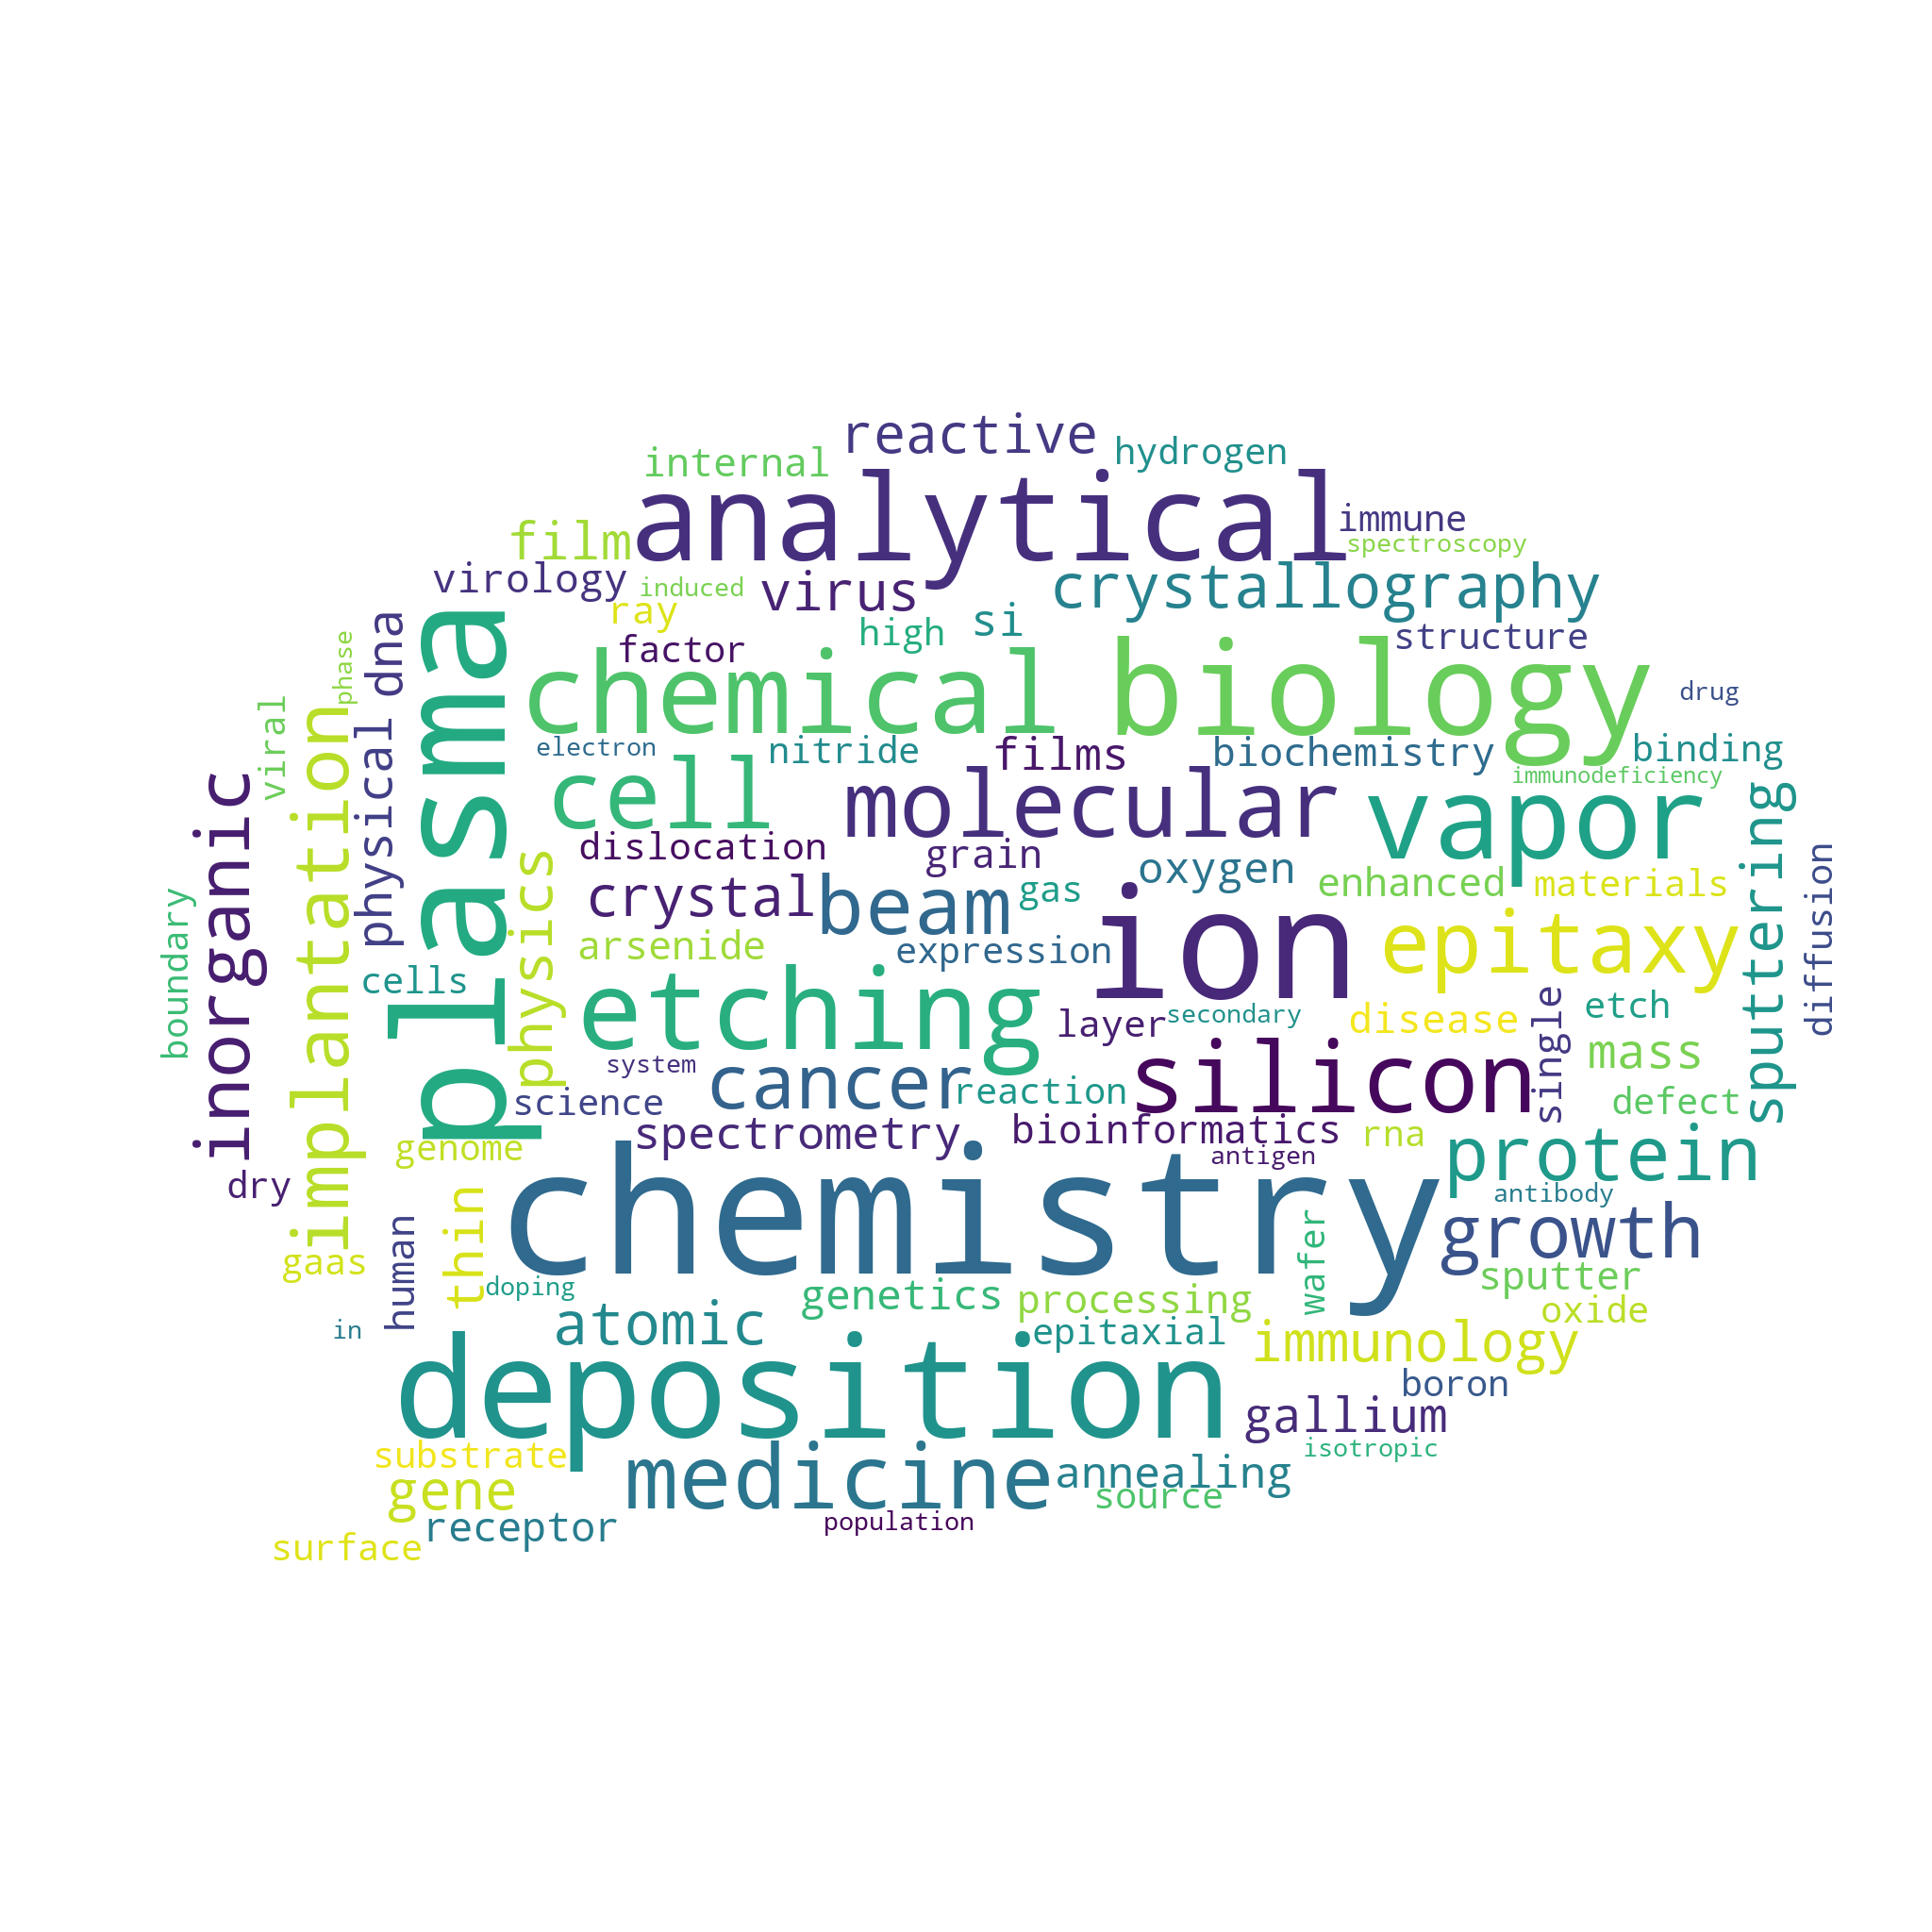

In [24]:
Topic_Word_Cloud(lda, feature_dict, 14).to_image()

In [21]:
# topic 7,12,13,14 as esg topic here
print((unique_paper_df['topic']==7).sum())
print((unique_paper_df['topic']==12).sum())
print((unique_paper_df['topic']==13).sum())
print((unique_paper_df['topic']==14).sum())

23526
9182
16815
16270


## Output LDA features and labels

In [145]:
output_df = unique_paper_df[['id', 'title', 'paper_type', 'paper_date', 'citation', 'keywords', 'features', 'topic']].copy()
def List_to_String(x):
    if type(x) is float:
        return ''
    else:
        x = [str(i) for i in x]
        return ','.join(x)
temp_df = unique_paper_df.copy()
output_df['AuId'] = temp_df['AuId'].apply(List_to_String)
output_df['AfId'] = temp_df['AfId'].apply(List_to_String)
output_df['AuN']  = temp_df['AuN'].apply(List_to_String)
output_df['AfN']  = temp_df['AfN'].apply(List_to_String)
output_df['FId']  = temp_df['FId'].fillna(0.1).apply(List_to_String)
output_df['FN']   = temp_df['FN'].fillna(0.1).apply(List_to_String)


In [146]:
output_df.head()

,id,title,paper_type,paper_date,citation,keywords,features,topic,AuId,AfId,AuN,AfN,FId,FN
0,2504791311,electric switchboard and circuits,Patents,1901-08-24,0,"circuits,electric,switchboard","circuits,electric,switchboard,electronic circu...",16,2567700084,1311269955,apple vincent g,apple inc,"134146338,24326235,41008148","electronic circuit,computer science,electronic..."
1,2418830571,machine for packing pulverulent and mastic sub...,Patents,1902-07-19,1,"machine,mastic,packing,pulverulent,substances","machine,mastic,packing,pulverulent,substances,...",27,2567700084,1311269955,apple vincent g,apple inc,"159985019,192562407","composite material,materials science"
2,2464829574,device for storing and administering serums,Patents,1903-03-07,12,"administering,device,serums,storing","administering,device,serums,storing,materials ...",9,"2599535238,2597534574",1311269955,"harry k mundorf,william s apple",apple inc,192562407,materials science
3,2423344776,zinc cup for primary batteries,Patents,1903-03-23,1,"batteries,cup,primary,zinc","batteries,cup,primary,zinc,metallurgy,material...",13,2567700084,1311269955,apple vincent g,apple inc,"535196362,191897082,192562407","metallurgy,materials science,zinc"
4,2413303928,automatic friction governor,Patents,1903-05-02,0,"automatic,friction,governor","automatic,friction,governor,engineering,govern...",28,2567700084,1311269955,apple vincent g,apple inc,"127413603,2781233147,65244806","engineering,governor,control theory"


In [245]:
output_df.to_csv(path + 'scholar_data/lda30_features+label.csv', index=0)

## Add manual label into the data and compare with LDA result

In [25]:
topic_df = pd.read_csv(path + 'scholar_data/lda30_features+label.csv')

In [26]:
topic_df = topic_df[~topic_df.FN.isnull()]
topic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722070 entries, 0 to 737390
Data columns (total 14 columns):
id            722070 non-null int64
title         722070 non-null object
paper_type    722070 non-null object
paper_date    722070 non-null object
citation      722070 non-null int64
keywords      722070 non-null object
features      722070 non-null object
topic         722070 non-null int64
AuId          722070 non-null object
AfId          722070 non-null object
AuN           722070 non-null object
AfN           722070 non-null object
FId           722070 non-null object
FN            722070 non-null object
dtypes: int64(3), object(11)
memory usage: 82.6+ MB


In [27]:
# choose only topic # 7, 12,13,14 for esg papers
esg_paper_df = topic_df[topic_df['topic'].isin([7,12,13,14])].reset_index(drop=True)
esg_paper_df.shape

(65101, 14)

### Get Ticker Symbol

In [410]:
# then manually fix the wrong part and load in again
#ticker_df = pd.read_csv(path+'financial/ticker_reference1.csv')
ticker_df = pd.read_csv(path+'financial/WRDS/stock_name_ticker_reference.csv')
ticker_df = ticker_df[['tic','conm','gsector']].drop_duplicates().reset_index(drop=True)

In [411]:
import re
ticker_df['conm'] = ticker_df['conm'].apply(str.lower).apply(lambda x:re.sub(r'[^\w]', ' ', x))
ticker_df.head()

,tic,conm,gsector
0,ANTQ,a a importing co inc,25.0
1,AIR,aar corp,20.0
2,ABSI,abs industries inc,15.0
3,4165A,acf industries holding corp,20.0
4,ACSE,acs enterprises inc,25.0


In [373]:
# transform AfN to unique institute
esg_paper_df['company_name'] = esg_paper_df['AfN'].apply(lambda x:x.split(','))

s = esg_paper_df.apply(lambda x: pd.Series(x['company_name']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'company_name'
df2 = esg_paper_df.drop('company_name', axis=1).join(s)
df2['company_name'] = pd.Series(df2['company_name'], dtype=object)


In [412]:
# remove non-company item from scholar data
esg_paper_df = df2[['id', 'title', 'paper_type', 'paper_date', 'citation', 'topic', 'FN', 'company_name']].reset_index(drop=True)
esg_paper_df = esg_paper_df[['university' not in name for name in esg_paper_df.company_name]]
esg_paper_df = esg_paper_df[['institute'  not in name for name in esg_paper_df.company_name]]
esg_paper_df = esg_paper_df[['college'    not in name for name in esg_paper_df.company_name]]


In [413]:
from collections import Counter

scholar_conm = esg_paper_df.company_name.unique()
names_freq = Counter()
for name in scholar_conm:
    names_freq.update(str(name).split(' '))
key_words = [word for (word,_) in names_freq.most_common(50)]
print(key_words)

['of', 'center', 'research', 'hospital', 'and', 'for', 'national', 'de', 'medical', 'corporation', 'health', 'laboratory', 'united', 'sciences', 's', 'international', 'centre', 'science', 'states', 'academy', 'department', 'inc', 'agency', 'technology', 'foundation', 'royal', 'service', 'energy', 'society', 'systems', 'school', 'american', 'council', 'company', 'the', 'group', 'observatory', 'cancer', 'institut', 'general', 'ecole', 'association', 'universidade', 'federal', 'children', 'naval', 'new', 'state', 'ministry', 'universite']


In [398]:
# matching by grouping
# group names by the first character; then match by groups;
fuzzymatch_df = pd.DataFrame(columns=['group','names','alias','score'])
scholar_conm.sort()
fuzzymatch_df['names'] = scholar_conm
fuzzymatch_df['group'] = fuzzymatch_df['names'].apply(lambda x:x[0])


In [377]:
from fuzzywuzzy import fuzz

ticker_df['group'] = ticker_df['conm'].apply(lambda x:x[0])
for i in range(len(fuzzymatch_df)):
    scholar_name = fuzzymatch_df.loc[i,'names']
    group = fuzzymatch_df.loc[i,'group']
    score = {}
    ref_list = ticker_df[ticker_df['group']==group]['conm'].tolist()
    for ref in ref_list:
        score[ref] = fuzz.partial_ratio(ref, scholar_name)
    fuzzymatch_df.loc[i,'alias'] = max(score, key=score.get)
    fuzzymatch_df.loc[i,'score'] = max(score.values())
    

In [415]:
fuzzymatch_95 = fuzzymatch_df[fuzzymatch_df['score']>=95]
fuzzymatch_95 = pd.merge(fuzzymatch_95,ticker_df,left_on='alias',right_on='conm',how='left')
fuzzymatch_95 = fuzzymatch_95[~fuzzymatch_95.gsector.isnull()]
fuzzymatch_95 = fuzzymatch_95[['names','tic']]
fuzzymatch_95.columns = ['company_name','tic']
# names from scholaf data, alias from ticker reference
ref_df1 = pd.read_csv(path+'financial/ticker_reference1.csv')
ref_df1.columns = ['company_name','tic']
ticker_ref = fuzzymatch_95.append(ref_df1)
ticker_ref = ticker_ref.drop_duplicates(['company_name'],keep='last')

esg_paper_df = pd.merge(esg_paper_df,ticker_ref,on='company_name',how='inner')
print(esg_paper_df.shape)

(62243, 9)


In [428]:
esg_paper_df.head()

,id,title,paper_type,paper_date,citation,topic,FN,company_name,tic
0,2423344776,zinc cup for primary batteries,Patents,1903-03-23,1,13,"zinc,metallurgy,materials science",apple inc,AAPL
1,2294937061,bees and fruit culture,Journal publications,1921-06-01,0,12,"biology,botany",apple inc,AAPL
2,2302050971,apples in britain,Journal publications,1921-11-01,0,12,"biology,ecology,zoology",apple inc,AAPL
3,2304350467,relative to the two queen system,Journal publications,1921-12-01,0,12,"queen,biology,ecology,zoology",apple inc,AAPL
4,2241826209,accelerator controlled automotive transmission,Patents,1934-03-06,5,12,"transmission,automotive industry,automotive en...",apple inc,AAPL


In [417]:
# output scholar data ticker list
scholar_data_ticker_list = esg_paper_df['tic'].unique().tolist()
scholar_data_ticker_list = ('\n').join(scholar_data_ticker_list)

with open(path + 'company_list/scholar_data_ticker_list.txt', 'w') as file:
    file.write(scholar_data_ticker_list)

In [425]:
print(f'# of stocks in pool: {esg_paper_df.tic.nunique()}')
print(f'start date: {min(esg_paper_df.paper_date)}')
print(f'end date: {max(esg_paper_df.paper_date)}')
print(f'# of unique papers: {esg_paper_df.id.nunique()}')

# of stocks in pool: 93
start date: 1870-02-01
end date: 2019-06-01
# of unique papers: 61908


In [427]:
# paper types
esg_paper_df[['id','paper_type']].drop_duplicates()['paper_type'].value_counts()/len(esg_paper_df[['id','paper_type']].drop_duplicates())

Journal publications       0.634878
Patents                    0.230423
Articles                   0.085595
Conference publications    0.048814
Books                      0.000162
Others                     0.000129
Name: paper_type, dtype: float64

### Scholar data feature engineering

### Monthly count & citations

In [450]:
import warnings
warnings.filterwarnings('ignore')

feature_df = esg_paper_df[['id','paper_date','paper_type','tic','citation','topic']]
feature_df['paper_month'] = feature_df['paper_date'].apply(lambda x:x[:-3])
feature_df.columns = ['id', 'paper_date', 'paper_type', 'ticker', 'citation', 'topic', 'paper_month']


In [451]:
# scholar data feature engineering

# total
total_df = feature_df.groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
total_df.columns = ['total_count', 'total_citation']
total_df = total_df.reset_index()

# journal
journal_df = feature_df[feature_df['paper_type']=='Journal publications'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
journal_df.columns = ['journal_count', 'journal_citation']
journal_df = journal_df.reset_index()

# patent
patent_df = feature_df[feature_df['paper_type']=='Patents'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
patent_df.columns = ['patent_count', 'patent_citation']
patent_df = patent_df.reset_index()

# article
article_df = feature_df[feature_df['paper_type']=='Articles'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
article_df.columns = ['article_count', 'article_citation']
article_df = article_df.reset_index()

# conference
conference_df = feature_df[feature_df['paper_type']=='Conference publications'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
conference_df.columns = ['conference_count', 'conference_citation']
conference_df = conference_df.reset_index()

# book
book_df = feature_df[feature_df['paper_type']=='Books'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
book_df.columns = ['book_count', 'book_citation']
book_df = book_df.reset_index()


In [452]:
# merge tables
scholar_feature = pd.merge(left=total_df, right=journal_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=patent_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=article_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=conference_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=book_df, how='left', on=['paper_month','ticker'])

scholar_feature = scholar_feature.fillna(0)

### Cumulative Sum Counts & Citations

In [453]:
# total cumsum
sum_total_df = feature_df.groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
sum_total_df.columns = ['total_count', 'total_citation']
sum_total_df = sum_total_df.reset_index()
sum_total_df['total_count_cumsum'] = sum_total_df.groupby('ticker')['total_count'].cumsum()
sum_total_df['total_citation_cumsum'] = sum_total_df.groupby('ticker')['total_citation'].cumsum()

# journal cumsum
sum_journal_df = feature_df[feature_df['paper_type']=='Journal publications'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
sum_journal_df.columns = ['journal_count', 'journal_citation']
sum_journal_df = sum_journal_df.reset_index()
sum_journal_df['journal_count_cumsum'] = sum_journal_df.groupby('ticker')['journal_count'].cumsum()
sum_journal_df['journal_citation_cumsum'] = sum_journal_df.groupby('ticker')['journal_citation'].cumsum()

# patent cumsum
sum_patent_df = feature_df[feature_df['paper_type']=='Patents'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
sum_patent_df.columns = ['patent_count', 'patent_citation']
sum_patent_df = sum_patent_df.reset_index()
sum_patent_df['patent_count_cumsum'] = sum_patent_df.groupby('ticker')['patent_count'].cumsum()
sum_patent_df['patent_citation_cumsum'] = sum_patent_df.groupby('ticker')['patent_citation'].cumsum()

# article cumsum
sum_article_df = feature_df[feature_df['paper_type']=='Articles'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
sum_article_df.columns = ['article_count', 'article_citation']
sum_article_df = sum_article_df.reset_index()
sum_article_df['article_count_cumsum'] = sum_article_df.groupby('ticker')['article_count'].cumsum()
sum_article_df['article_citation_cumsum'] = sum_article_df.groupby('ticker')['article_citation'].cumsum()

# conference cumsum
sum_conference_df = feature_df[feature_df['paper_type']=='Conference publications'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
sum_conference_df.columns = ['conference_count', 'conference_citation']
sum_conference_df = sum_conference_df.reset_index()
sum_conference_df['conference_count_cumsum'] = sum_conference_df.groupby('ticker')['conference_count'].cumsum()
sum_conference_df['conference_citation_cumsum'] = sum_conference_df.groupby('ticker')['conference_citation'].cumsum()

# book cumsum
sum_book_df = feature_df[feature_df['paper_type']=='Books'].groupby(['paper_month','ticker']).agg({'id': 'count', 'citation': 'sum'})
sum_book_df.columns = ['book_count', 'book_citation']
sum_book_df = sum_book_df.reset_index()
sum_book_df['book_count_cumsum'] = sum_book_df.groupby('ticker')['book_count'].cumsum()
sum_book_df['book_citation_cumsum'] = sum_book_df.groupby('ticker')['book_citation'].cumsum()


In [454]:
# merge cumsum into table
scholar_feature = pd.merge(left=scholar_feature, 
                           right=sum_total_df[['paper_month','ticker','total_count_cumsum','total_citation_cumsum']],
                           how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, 
                           right=sum_journal_df[['paper_month','ticker','journal_count_cumsum','journal_citation_cumsum']],
                           how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, 
                           right=sum_patent_df[['paper_month','ticker','patent_count_cumsum','patent_citation_cumsum']],
                           how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, 
                           right=sum_article_df[['paper_month','ticker','article_count_cumsum','article_citation_cumsum']],
                           how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, 
                           right=sum_conference_df[['paper_month','ticker','conference_count_cumsum','conference_citation_cumsum']],
                           how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, 
                           right=sum_book_df[['paper_month','ticker','book_count_cumsum','book_citation_cumsum']],
                           how='left', on=['paper_month','ticker'])

#scholar_feature = scholar_feature.fillna(0)

### Monthly Average and Max Citations

In [455]:
# total citation
total_citation_df = feature_df.groupby(['paper_month','ticker']).agg({'citation':['max','mean']})
total_citation_df.columns = ['total_max_citation', 'total_average_citation']
total_citation_df = total_citation_df.reset_index()

# patent citation
patent_citation_df = feature_df[feature_df['paper_type']=='Patents'].groupby(['paper_month','ticker']).agg({'citation':['max','mean']})
patent_citation_df.columns = ['patent_max_citation', 'patent_average_citation']
patent_citation_df = patent_citation_df.reset_index()

# journal citation
journal_citation_df = feature_df[feature_df['paper_type']=='Journal publications'].groupby(['paper_month','ticker']).agg({'citation':['max','mean']})
journal_citation_df.columns = ['journal_max_citation', 'journal_average_citation']
journal_citation_df = journal_citation_df.reset_index()

# article citation
article_citation_df = feature_df[feature_df['paper_type']=='Articles'].groupby(['paper_month','ticker']).agg({'citation':['max','mean']})
article_citation_df.columns = ['article_max_citation', 'article_average_citation']
article_citation_df = article_citation_df.reset_index()

# conference citation
conference_citation_df = feature_df[feature_df['paper_type']=='Conference publications'].groupby(['paper_month','ticker']).agg({'citation':['max','mean']})
conference_citation_df.columns = ['conference_max_citation', 'conference_average_citation']
conference_citation_df = conference_citation_df.reset_index()

# book citation
book_citation_df = feature_df[feature_df['paper_type']=='Books'].groupby(['paper_month','ticker']).agg({'citation':['max','mean']})
book_citation_df.columns = ['book_max_citation', 'book_average_citation']
book_citation_df = book_citation_df.reset_index()


In [456]:
# merge max and avg citation into table
scholar_feature = pd.merge(left=scholar_feature, right=total_citation_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=patent_citation_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=journal_citation_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=article_citation_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=conference_citation_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=book_citation_df, how='left', on=['paper_month','ticker'])

scholar_feature = scholar_feature.fillna(0)

### Monthly & Cumulative Sum Relative Counts

In [460]:
# get relative count of each paper

# find topic rank for each year
unique_paper_df['paper_year'] = unique_paper_df['paper_date'].apply(lambda x:x[:4]).astype('int')
feature_df['paper_year'] = feature_df['paper_month'].apply(lambda x:x[:4]).astype('int')

def Get_Num_Hot_Lastyear(df):
    topic = df['topic']
    year = df['paper_year']
    if year-1 not in unique_paper_df.paper_year: return 1
    tlist = unique_paper_df[unique_paper_df.paper_year==(year-1)]['topic'].tolist()
    ct = max(tlist.count(topic),1)
    
    return 1/ct
    
feature_df['relative_count'] = feature_df[['topic', 'paper_year']].apply(Get_Num_Hot_Lastyear,axis=1)
    

In [461]:
# get monthly relative count

# total count
total_relative_df = feature_df.groupby(['paper_month','ticker'])['relative_count'].apply(sum)
total_relative_df = total_relative_df.reset_index()
total_relative_df.columns = ['paper_month', 'ticker', 'total_count_relative']
total_relative_df['total_count_relative_cumsum'] = total_relative_df.groupby('ticker')['total_count_relative'].cumsum()

# journal count
journal_relative_df = feature_df[feature_df['paper_type']=='Journal publications'].groupby(['paper_month','ticker'])['relative_count'].apply(sum)
journal_relative_df = journal_relative_df.reset_index()
journal_relative_df.columns = ['paper_month', 'ticker', 'journal_count_relative']
journal_relative_df['journal_count_relative_cumsum'] = journal_relative_df.groupby('ticker')['journal_count_relative'].cumsum()

# patent count
patent_relative_df = feature_df[feature_df['paper_type']=='Patents'].groupby(['paper_month','ticker'])['relative_count'].apply(sum)
patent_relative_df = patent_relative_df.reset_index()
patent_relative_df.columns = ['paper_month', 'ticker', 'patent_count_relative']
patent_relative_df['patent_count_relative_cumsum'] = patent_relative_df.groupby('ticker')['patent_count_relative'].cumsum()

# article count
article_relative_df = feature_df[feature_df['paper_type']=='Articles'].groupby(['paper_month','ticker'])['relative_count'].apply(sum)
article_relative_df = article_relative_df.reset_index()
article_relative_df.columns = ['paper_month', 'ticker', 'article_count_relative']
article_relative_df['article_count_relative_cumsum'] = article_relative_df.groupby('ticker')['article_count_relative'].cumsum()

# conference count
conference_relative_df = feature_df[feature_df['paper_type']=='Conference publications'].groupby(['paper_month','ticker'])['relative_count'].apply(sum)
conference_relative_df = conference_relative_df.reset_index()
conference_relative_df.columns = ['paper_month', 'ticker', 'conference_count_relative']
conference_relative_df['conference_count_relative_cumsum'] = conference_relative_df.groupby('ticker')['conference_count_relative'].cumsum()

# book count
book_relative_df = feature_df[feature_df['paper_type']=='Books'].groupby(['paper_month','ticker'])['relative_count'].apply(sum)
book_relative_df = book_relative_df.reset_index()
book_relative_df.columns = ['paper_month', 'ticker', 'book_count_relative']
book_relative_df['book_count_relative_cumsum'] = book_relative_df.groupby('ticker')['book_count_relative'].cumsum()



In [462]:
# merge into table
scholar_feature = pd.merge(left=scholar_feature, right=total_relative_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=journal_relative_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=patent_relative_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=article_relative_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=conference_relative_df, how='left', on=['paper_month','ticker'])
scholar_feature = pd.merge(left=scholar_feature, right=book_relative_df, how='left', on=['paper_month','ticker'])



### Fill NA

In [463]:
# for count fillna with 0
month_col = ['journal_count_relative','patent_count_relative','article_count_relative',
             'conference_count_relative','book_count_relative']
scholar_feature[month_col] = scholar_feature[month_col].fillna(0)

# for cumsum fillna with groupby same ticker previous paper_month
cum_col = ['journal_count_relative_cumsum','patent_count_relative_cumsum','article_count_relative_cumsum',
           'conference_count_relative_cumsum','book_count_relative_cumsum']
for col in cum_col:
    scholar_feature[col] = scholar_feature.groupby('ticker')[col].ffill()
    scholar_feature[col] = scholar_feature[col].fillna(0)


In [464]:
scholar_feature.isnull().sum()

paper_month                         0
ticker                              0
total_count                         0
total_citation                      0
journal_count                       0
journal_citation                    0
patent_count                        0
patent_citation                     0
article_count                       0
article_citation                    0
conference_count                    0
conference_citation                 0
book_count                          0
book_citation                       0
total_count_cumsum                  0
total_citation_cumsum               0
journal_count_cumsum                0
journal_citation_cumsum             0
patent_count_cumsum                 0
patent_citation_cumsum              0
article_count_cumsum                0
article_citation_cumsum             0
conference_count_cumsum             0
conference_citation_cumsum          0
book_count_cumsum                   0
book_citation_cumsum                0
total_max_ci

In [467]:
scholar_feature.shape

(9128, 50)

In [470]:
print(f'# of unique stocks: {scholar_feature.ticker.nunique()}')
print(f'start date: {scholar_feature.paper_month.min()}')
print(f'end date: {scholar_feature.paper_month.max()}')

# of unique stocks: 93
start date: 1870-02
end date: 2019-06


## Output Scholar Features 

In [471]:
scholar_feature.to_csv(path+'scholar_data/scholar_features.csv',index=0)